### Titulars of Credits and debits cards in argentina.

<u>*Some key points regarding the data:*</u>

* Information for this analysis has been downloaded from the Argentinian Central Bank, BCRA.

* This information resumes the amount of titulars of financial products offered by the argentinian financial entities.
* The Raw data used can be found in the following link, and in the excel file from above.

* This data was transformed into a version more usable for pandas and python point of view. The ETL Process is resumed in the ETL.ipynb

* Data was previously in Spanish and has been translated into English.



#### Import some libraries

In [1]:
import pandas as pd #Install xrld dependency    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import datetime as dt

import re

import plotly.express as px
from jupyter_dash import JupyterDash

from dash import html, dcc
from dash.dependencies import Input, Output

from pathlib import Path

import csv

#### Import Dataset

In [184]:
df_path = "C:\\Users\\Alejandro\\Desktop\\Alpha Project\\Code\\Credit_debit_report\\final_cards.csv"
df = pd.read_csv(df_path, sep=";", index_col="date")

#### Translate data_frame

In [185]:
df = df.rename({"entidades_financieras":"financial_entities",
                "instrumento":"card_type",
                "cantidad_titulares":"card_holders_cumulative",
                "cantidad_titulares_var":"card_holders_variation"}, axis=1)

In [186]:
# List with financial entities
financial_entities_esp = list(df.financial_entities.unique())
financial_entities_eng = ["Total", "national state banks", "provincial state banks", "municipal state banks",
                          "national capital banks", "foreign capital local banks", "Branches of foreign financial institutions", 
                          "financial companies", "credit unions"]

# List with card_types
#card_type_esp = list(df.card_type.unique())
card_type_esp = list(df.card_type.unique())
card_type_eng = ["credit card", "credit cards extensions", "debit cards"]

In [187]:
def translate_columns(data_frame:pd.DataFrame, column_name:str, values_lang_old:list, values_lang_new:list) -> pd.DataFrame:
    for entity in range(len(values_lang_old)):
        data_frame = data_frame.replace({column_name:{values_lang_old[entity]:values_lang_new[entity]}})

    
    return data_frame



In [188]:
c_df = translate_columns(data_frame=df, column_name ="financial_entities", values_lang_old=financial_entities_esp, values_lang_new=financial_entities_eng)
c_df = translate_columns(data_frame=c_df, column_name ="card_type", values_lang_old=card_type_esp, values_lang_new=card_type_eng)
c_df


,financial_entities,card_type,card_holders_cumulative,card_holders_variation
date,,,,
2001-12-31,Total,credit card,6671825,6671825
2001-12-31,Total,credit cards extensions,3756116,3756116
2001-12-31,Total,debit cards,0,0
2001-12-31,national state banks,credit card,237329,237329
2001-12-31,national state banks,credit cards extensions,169446,169446
...,...,...,...,...
2022-12-31,financial companies,credit cards extensions,0,0
2022-12-31,financial companies,debit cards,0,0
2022-12-31,credit unions,credit card,0,0


#### Correct Data types

In [189]:
c_df["financial_entities"] = c_df["financial_entities"].astype("category")
c_df["card_type"] = c_df["card_type"].astype("category")
c_df = c_df.reset_index()
c_df["date"] = pd.to_datetime(c_df["date"], format= "%Y-%m-%d")
c_df = c_df.set_index("date")

c_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2295 entries, 2001-12-31 to 2022-12-31
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   financial_entities       2295 non-null   category
 1   card_type                2295 non-null   category
 2   card_holders_cumulative  2295 non-null   int64   
 3   card_holders_variation   2295 non-null   int64   
dtypes: category(2), int64(2)
memory usage: 58.8 KB


#### Insights - Time Series Analysis

In [190]:
c_df["year"] = c_df.index.year
c_df["month"] = c_df.index.month


In [291]:
total_values = c_df["financial_entities"] == "Total"
total_df = c_df[total_values]
total_df

,financial_entities,card_type,card_holders_cumulative,card_holders_variation,year,month
date,,,,,,
2001-12-31,Total,credit card,6671825,6671825,2001,12
2001-12-31,Total,credit cards extensions,3756116,3756116,2001,12
2001-12-31,Total,debit cards,0,0,2001,12
2002-03-31,Total,credit card,5942445,-729380,2002,3
2002-03-31,Total,credit cards extensions,3874612,118496,2002,3
...,...,...,...,...,...,...
2022-09-30,Total,credit cards extensions,0,-10876841,2022,9
2022-09-30,Total,debit cards,0,-66698637,2022,9
2022-12-31,Total,credit card,0,0,2022,12


In [298]:
grouped_cards = total_df.groupby(["year", "card_type"])[["card_holders_cumulative"]].agg({"card_holders_cumulative":["mean"]})/1_000_000
#grouped_cards = grouped_cards.rename(columns={"card_holders_variation":"card_holders_var_millions"})
grouped_cards = grouped_cards.reset_index()
grouped_cards["year"] = pd.to_datetime(grouped_cards["year"], format="%Y")
grouped_cards = grouped_cards.set_index("year")



In [249]:
grouped_cards["card_holders_cumulative"].corr(method="pearson")

,mean
mean,1.0


In [266]:
def calculate_correlation(df:pd.DataFrame, column_to_pivot:str, period_start:int, period_end:int)-> pd.DataFrame:
    correlation = df.pivot(columns=[column_to_pivot]).loc[period_start:period_end,].corr("pearson")

    return correlation



In [268]:
calculate_correlation(df=grouped_cards, column_to_pivot="card_type",period_start=2010, period_end=2015)

card_holders_cumulative  \
                                                                        mean   
card_type                                                        credit card   
                             card_type                                         
card_holders_cumulative mean credit card                            1.000000   
                             credit cards extensions                0.980529   
                             debit cards                            0.964161   

                                                                              \
                                                                               
card_type                                            credit cards extensions   
                             card_type                                         
card_holders_cumulative mean credit card                            0.980529   
                             credit cards extensions                1.000000   
                             debit cards                            0.993500   

                                                                  
                                                                  
card_type                                            debit cards  
                             card_type                            
card_holders_cumulative mean credit card                0.964161  
                             credit cards extensions    0.993500  
                             debit cards                1.000000

In [273]:
calculate_correlation(df=grouped_cards, column_to_pivot="card_type",period_start=2016, period_end=2018)

card_holders_cumulative  \
                                                                        mean   
card_type                                                        credit card   
                             card_type                                         
card_holders_cumulative mean credit card                            1.000000   
                             credit cards extensions                0.997205   
                             debit cards                            0.991280   

                                                                              \
                                                                               
card_type                                            credit cards extensions   
                             card_type                                         
card_holders_cumulative mean credit card                            0.997205   
                             credit cards extensions                1.000000   
                             debit cards                            0.998354   

                                                                  
                                                                  
card_type                                            debit cards  
                             card_type                            
card_holders_cumulative mean credit card                0.991280  
                             credit cards extensions    0.998354  
                             debit cards                1.000000

In [275]:
calculate_correlation(df=grouped_cards, column_to_pivot="card_type",period_start=2018, period_end=2021)


card_holders_cumulative  \
                                                                        mean   
card_type                                                        credit card   
                             card_type                                         
card_holders_cumulative mean credit card                            1.000000   
                             credit cards extensions                0.887472   
                             debit cards                           -0.885664   

                                                                              \
                                                                               
card_type                                            credit cards extensions   
                             card_type                                         
card_holders_cumulative mean credit card                            0.887472   
                             credit cards extensions                1.000000   
                             debit cards                           -0.698305   

                                                                  
                                                                  
card_type                                            debit cards  
                             card_type                            
card_holders_cumulative mean credit card               -0.885664  
                             credit cards extensions   -0.698305  
                             debit cards                1.000000

<AxesSubplot:xlabel='year'>

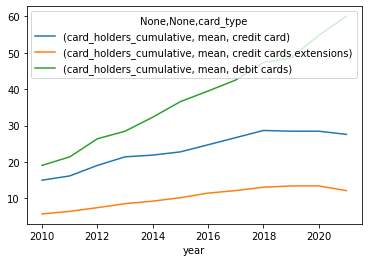

In [281]:
grouped_cards.pivot(columns=["card_type"]).loc[2010:2021,].plot()

<AxesSubplot:xlabel='year'>

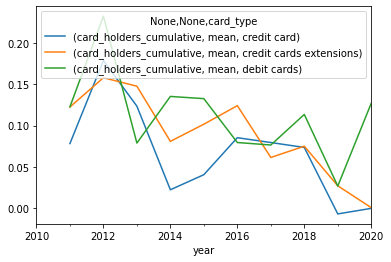

In [303]:
grouped_cards.pivot(columns=["card_type"]).loc["2010":"2020",].pct_change().plot()

In [317]:
debit_df = c_df["card_type"] == "debit cards"
debit_df = c_df[debit_df]

In [364]:
entities_df = debit_df.groupby(["year", "financial_entities"])[["card_holders_cumulative"]].agg({"card_holders_cumulative":["mean"]})/1_000_000

entities_df = entities_df.reset_index()
entities_df["year"] = pd.to_datetime(entities_df["year"], format="%Y")
entities_df = entities_df.set_index("year")
entities_df.columns = entities_df.columns.droplevel()
entities_df = entities_df.rename(columns={"mean":"mean_card_holders", '':"financial_entities"})

In [365]:
entities_df

,financial_entities,mean_card_holders
year,,
2001-01-01,Branches of foreign financial institutions,1.035326
2001-01-01,Total,0.000000
2001-01-01,credit unions,0.000000
2001-01-01,financial companies,0.181750
2001-01-01,foreign capital local banks,3.844925
...,...,...
2022-01-01,foreign capital local banks,6.797984
2022-01-01,municipal state banks,0.519893
2022-01-01,national capital banks,11.452943


In [361]:

entities_df.pivot(columns=["financial_entities"])["2009":"2021"].pct_change().dropna()

mean_card_holders            \
financial_entities Branches of foreign financial institutions     Total   
year                                                                      
2010-01-01                                          -0.019539  1.093006   
2011-01-01                                           0.064968  0.122672   
2012-01-01                                           0.031122  0.232189   
2013-01-01                                          -0.006074  0.078894   
2014-01-01                                          -0.055286  0.135246   
2015-01-01                                          -0.014933  0.132567   
2016-01-01                                           0.015491  0.079530   
2017-01-01                                          -0.990688  0.076516   
2018-01-01                                           0.000000  0.113469   
2019-01-01                                           0.000000  0.026877   
2020-01-01                                           0.060671  0.127065   

                                                      \
financial_entities credit unions financial companies   
year                                                   
2010-01-01              0.168718           -0.946932   
2011-01-01              0.332758            0.352204   
2012-01-01              0.820031           40.833538   
2013-01-01             -0.203389            1.278957   
2014-01-01             -0.834048            0.129158   
2015-01-01             -0.069467           -0.088298   
2016-01-01              0.073495            0.079392   
2017-01-01              0.437736            0.067214   
2018-01-01              0.050244            0.021635   
2019-01-01             -0.533024            0.026615   
2020-01-01             -1.000000            0.087753   

                                                                      \
financial_entities foreign capital local banks municipal state banks   
year                                                                   
2010-01-01                           -0.005479              0.125690   
2011-01-01                            0.209327             -0.004881   
2012-01-01                            0.100152              0.160374   
2013-01-01                            0.045538              0.076170   
2014-01-01                            0.072393              0.093394   
2015-01-01                            0.074049              0.039861   
2016-01-01                            0.087232             -0.004769   
2017-01-01                            0.159856              0.103462   
2018-01-01                            0.069116              0.075676   
2019-01-01                            0.022517              0.037565   
2020-01-01                            0.091268              0.047448   

                                                                \
financial_entities national capital banks national state banks   
year                                                             
2010-01-01                       0.152967             1.004693   
2011-01-01                       0.013743             0.566999   
2012-01-01                       0.130300             0.979119   
2013-01-01                       0.149528             0.036165   
2014-01-01                       0.099769             0.391857   
2015-01-01                       0.087976             0.347601   
2016-01-01                       0.097651             0.029572   
2017-01-01                       0.048960             0.066130   
2018-01-01                       0.109066             0.224462   
2019-01-01                       0.054994            -0.013114   
2020-01-01                       0.124454             0.123718   

                                           
financial_entities provincial state banks  
year                                       
2010-01-01                       0.023243  
2011-01-01                       0.134804  
2012-01-01                       0.317494  
2013-01-01

In [325]:
entities_df.pivot(columns=["financial_entities"])["2009":"2021"].describe()

card_holders_cumulative             \
                                                         mean              
financial_entities Branches of foreign financial institutions      Total   
count                                               13.000000  13.000000   
mean                                                 0.204622  35.836008   
std                                                  0.166044  14.880653   
min                                                  0.003041   9.104628   
25%                                                  0.003220  26.361055   
50%                                                  0.321578  36.567516   
75%                                                  0.326560  47.318263   
max                                                  0.347670  60.012624   

                                                      \
                                                       
financial_entities credit unions financial companies   
count                  13.000000           13.000000   
mean                    0.001075            0.184266   
std                     0.001085            0.109940   
min                     0.000000            0.001656   
25%                     0.000432            0.093676   
50%                     0.000667            0.237219   
75%                     0.001448            0.258641   
max                     0.003512            0.288997   

                                                                      \
                                                                       
financial_entities foreign capital local banks municipal state banks   
count                                13.000000             13.000000   
mean                                  8.755027              0.804280   
std                                   2.679506              0.189881   
min                                   5.152632              0.512413   
25%                                   6.855283              0.666058   
50%                                   8.255499              0.811090   
75%                                  11.129978              0.962738   
max                                  12.969971              1.096809   

                                                                \
                                                                 
financial_entities national capital banks national state banks   
count                           13.000000            13.000000   
mean                            13.694744             6.358850   
std                              4.594146             4.009280   
min                              7.371192             0.595238   
25%                              9.738141             3.700661   
50%                             13.394184             7.192240   
75%                             17.103970             9.539898   
max                             21.345530            13.715946   

                                           
                                           
financial_entities provincial state banks  
count                           13.000000  
mean                             6.460080  
std                              2.425794  
min                              3.239573  
25%                              4.956054  
50%                              6.368834  
75%                              8.192533  
max                             10.592151

In [366]:
entities_df = entities_df.pivot(columns=["financial_entities"])["2009":"2021"]
#entities_df.columns =  entities_df.columns.drop_level()
entities_df

mean_card_holders             \
financial_entities Branches of foreign financial institutions      Total   
year                                                                       
2009-01-01                                           0.322916   9.104628   
2010-01-01                                           0.316607  19.056041   
2011-01-01                                           0.337176  21.393681   
2012-01-01                                           0.347670  26.361055   
2013-01-01                                           0.345558  28.440788   
2014-01-01                                           0.326454  32.287290   
2015-01-01                                           0.321578  36.567516   
2016-01-01                                           0.326560  39.475729   
2017-01-01                                           0.003041  42.496271   
2018-01-01                                           0.003041  47.318263   
2019-01-01                                           0.003041  48.590054   
2020-01-01                                           0.003226  54.764170   
2021-01-01                                           0.003220  60.012624   

                                                      \
financial_entities credit unions financial companies   
year                                                   
2009-01-01              0.001239            0.031206   
2010-01-01              0.001448            0.001656   
2011-01-01              0.001930            0.002239   
2012-01-01              0.003512            0.093676   
2013-01-01              0.002798            0.213483   
2014-01-01              0.000464            0.241056   
2015-01-01              0.000432            0.219771   
2016-01-01              0.000464            0.237219   
2017-01-01              0.000667            0.253164   
2018-01-01              0.000700            0.258641   
2019-01-01              0.000327            0.265525   
2020-01-01              0.000000            0.288825   
2021-01-01              0.000000            0.288997   

                                                                      \
financial_entities foreign capital local banks municipal state banks   
year                                                                   
2009-01-01                            5.181016              0.512413   
2010-01-01                            5.152632              0.576818   
2011-01-01                            6.231216              0.574003   
2012-01-01                            6.855283              0.666058   
2013-01-01                            7.167457              0.716792   
2014-01-01                            7.686335              0.783736   
2015-01-01                            8.255499              0.814976   
2016-01-01                            8.975641              0.811090   
2017-01-01                           10.410448              0.895007   
2018-01-01                           11.129978              0.962738   
2019-01-01                           11.380595              0.998903   
2020-01-01                           12.419278              1.046299   
2021-01-01                           12.969971              1.096809   

                                                                \
financial_entities national capital banks national state banks   
year                                                             
2009-01-01                       7.371192             0.595238   
2010-01-01                       8.498741             1.193270   
2011-01-01                       8.615536             1.869853   
2012-01-01                       9.738141             3.700661   
2013-01-01                      11.194267             3.834495   
2014-01-01                      12.311106             5.337071   
2015-01-01                      13.394184             7.192240   
2016-01-01                      14.702140             7.404933   
2017-01-01                      15.421964          

In [377]:
entities_df = entities_df["mean_card_holders"]

In [436]:
df = pd.DataFrame()

for column_name in list(entities_df.columns):
    
    df[column_name] = entities_df[column_name] / entities_df["Total"]

df = df.drop("Total", axis=1)
df = df*100
df = df.stack().to_frame()
df = df.reset_index().set_index("year")
df = df.rename(columns={df.columns.values[1]:"mean_ch_part", "level_1":"financial_entities"})
df

,financial_entities,mean_ch_part
year,,
2009-01-01,Branches of foreign financial institutions,3.546729
2009-01-01,credit unions,0.013606
2009-01-01,financial companies,0.342743
2009-01-01,foreign capital local banks,56.905303
2009-01-01,municipal state banks,5.628050
...,...,...
2021-01-01,foreign capital local banks,21.612070
2021-01-01,municipal state banks,1.827630
2021-01-01,national capital banks,35.568400


<AxesSubplot:xlabel='financial_entities', ylabel='mean_ch_part'>

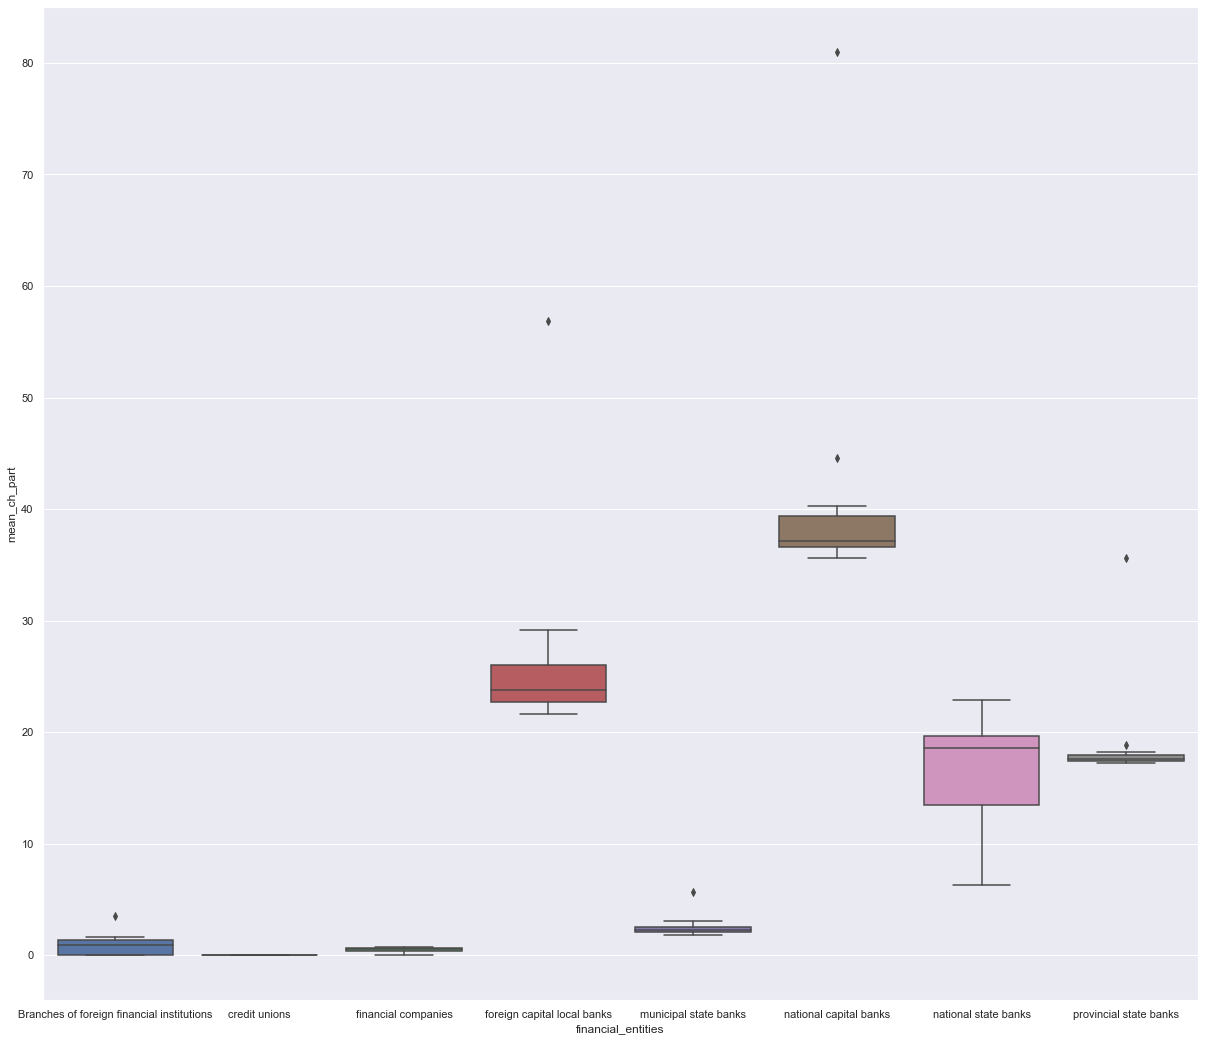

In [437]:
sns.set(rc={'figure.figsize':(20.7,18.27)})
sns.boxplot(data=df, x="financial_entities", y="mean_ch_part", orient="v")

<AxesSubplot:xlabel='year'>

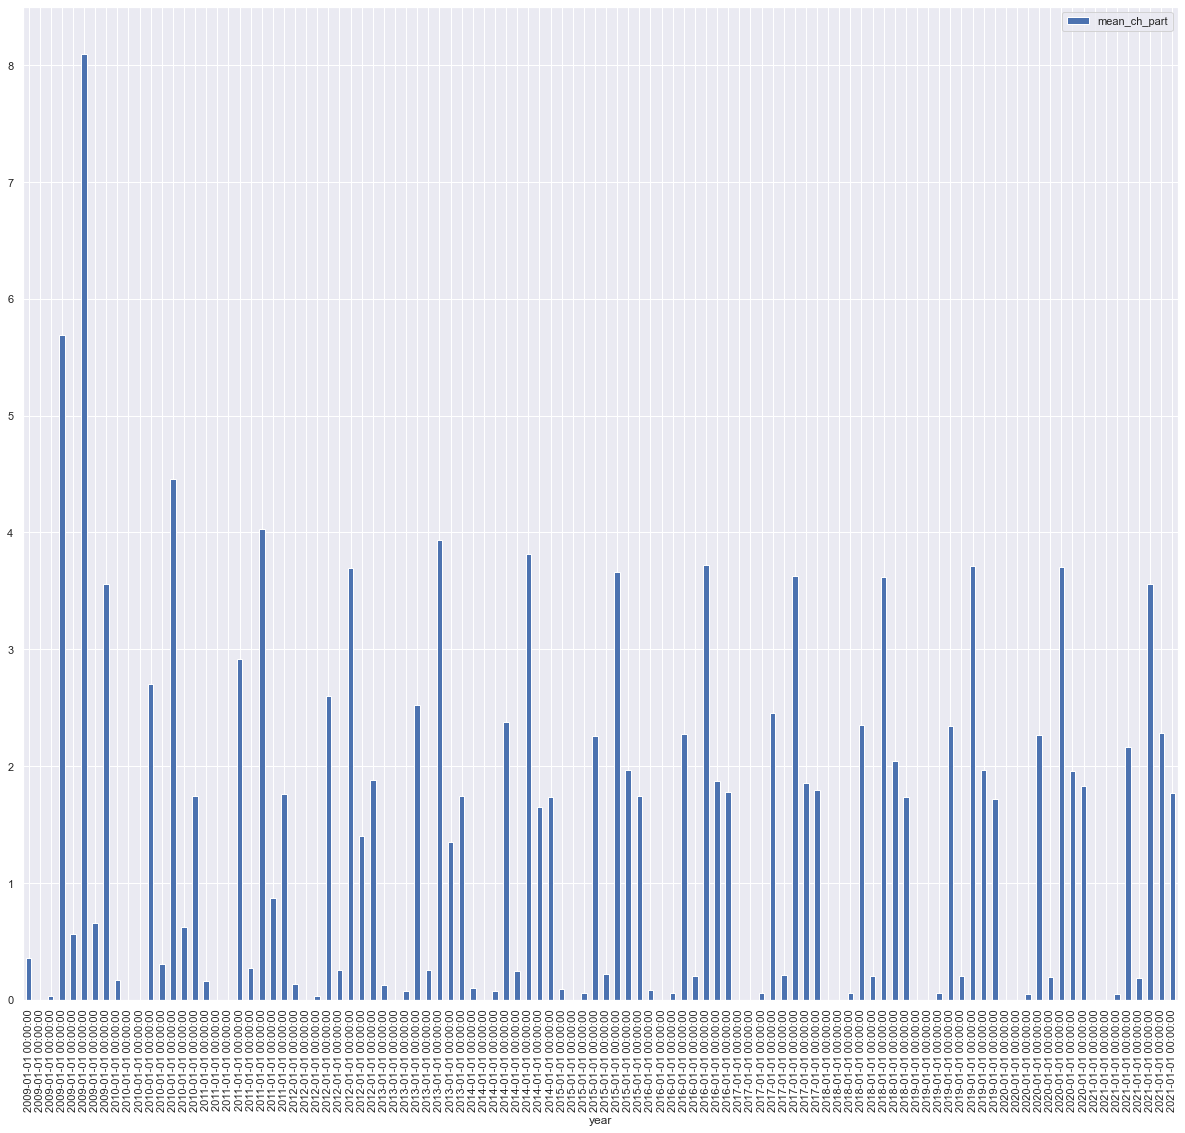

In [435]:
df.plot(kind='bar', stacked=True)